## Web scrapping using python

#### References
1. [Practical Introduction to Web Scraping in Python](https://realpython.com/python-web-scraping-practical-introduction/)
2. [Web Scraping using Python](https://www.datacamp.com/community/tutorials/web-scraping-using-python)

In [1]:
# $ python3 -m venv venv
# $ . ./venv/bin/activate

## Installing Beautiful soup for web scrapping


In [2]:
#Better
!pip install requests BeautifulSoup4 fire

You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


## importing necessary modules

In [3]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import pandas as pd
import os, sys

import fire

In [4]:
#%%writefile ../pyscrap_url.py

def simple_get(url):
    """
    Attempts to get the content at `url` by making an HTTP GET request.
    If the content-type of response is some kind of HTML/XML, return the
    text content, otherwise return None.
    """
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content  #.encode(BeautifulSoup.original_encoding)
            else:
                return None

    except RequestException as e:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None


def is_good_response(resp):
    """
    Returns True if the response seems to be HTML, False otherwise.
    """
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1)


def log_error(e):
    """
    It is always a good idea to log errors. 
    This function just prints them, but you can
    make it do anything.
    """
    print(e)
    
def get_elements(url, tag='',search={}, fname=None):
    """
    Downloads a page specified by the url parameter
    and returns a list of strings, one per tag element
    """
    
    if isinstance(url,str):
        response = simple_get(url)
    else:
        #if already it is a loaded html page
        response = url

    if response is not None:
        html = BeautifulSoup(response, 'html.parser')
        
        res = []
        if tag:    
            for li in html.select(tag):
                for name in li.text.split('\n'):
                    if len(name) > 0:
                        res.append(name.strip())
                       
                
        if search:
            soup = html            
            
            
            r = ''
            if 'find' in search.keys():
                print('findaing',search['find'])
                soup = soup.find(**search['find'])
                r = soup

                
            if 'find_all' in search.keys():
                print('finding all of',search['find_all'])
                r = soup.find_all(**search['find_all'])
   
            if r:
                for x in list(r):
                    if len(x) > 0:
                        res.extend(x)
            
        return res

    # Raise an exception if we failed to get any data from the url
    raise Exception('Error retrieving contents at {}'.format(url))    
    
    
if get_ipython().__class__.__name__ == '__main__':
    fire(get_tag_elements)

## Importing Modules

In [5]:
from __future__ import unicode_literals
import sys
import os
import json
import re
import string
import pandas as pd
import matplotlib.pyplot as plt

#install tweepy if you don't have it
!pip install tweepy
import json
import tweepy
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

#sentiment analysis package
!pip install textblob
from textblob import TextBlob

#general text pre-processor
!pip install nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

#tweet pre-processor 
!pip install tweet-preprocessor
import preprocessor as p
pd.set_option("display.max.columns", None)

You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


## Methods and functions of twitter api

In [31]:
class tweetsearch():
    def __init__(self, cols=None, auth=None):
        if not cols is None:
            self.cols = cols
        else:
            self.cols = [
                'id', 'created_at', 'source', 'original_text', 'clean_text',
                'sentiment', 'polarity', 'subjectivity','lang','favorite_count',
                'retweet_count','original_author', 'hashtgs','user_mentions',
                'followers', 'following', 'place_coordinates', 'place'
            ]
        if auth is None:
            
            consumer_key = "API_key"
            consumer_secret = "API_secret_key"
            access_token = "Access_token"
            access_token_secret = "Access_token_secret"
            # This handles Twitter authentication
            auth = OAuthHandler(consumer_key, consumer_secret)
            auth.set_access_token(access_token, access_token_secret)
        self.auth = auth
        self.api = tweepy.API(auth, wait_on_rate_limit=True)
        self.filtered_tweet = ''
    def clean_tweets(self, twitter_text):
        # use pre processor
        tweet = p.clean(twitter_text)
        #Happy Emoticons
        emoticons_happy = set([
            ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
            ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
            '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
            'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
            '<3'
            ])
        # Sad Emoticons
        emoticons_sad = set([
            ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
            ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
            ':c', ':{', '>:\\', ';('
            ])
        #Emoji patterns
        emoji_pattern = re.compile("["
                 u"\U0001F600-\U0001F64F"  # emoticons
                 u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                 u"\U0001F680-\U0001F6FF"  # transport & map symbols
                 u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                 u"\U00002702-\U000027B0"
                 u"\U000024C2-\U0001F251"
                 "]+", flags=re.UNICODE)
        # combine sad and happy emoticons
        emoticons = emoticons_happy.union(emoticons_sad)
        stop_words = set(stopwords.words('english'))
        word_tokens = nltk.word_tokenize(tweet)
        tweet = re.sub(r':', '', tweet)
        tweet = re.sub(r'‚Ä¶', '', tweet)
        #replace consecutive non-ASCII characters with a space
        tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
        #remove emojis from tweet
        tweet = emoji_pattern.sub(r'', tweet)
        #filter using NLTK library append it to a string
        filtered_tweet = [w for w in word_tokens if not w in stop_words]
        # looping through conditions
        filtered_tweet = []
        for w in word_tokens:
            # check tokens againts stop words, emoticons and punctuations
            if w not in stop_words and w not in emoticons and w not in string.punctuation:
                filtered_tweet.append(w)
        return ' '.join(filtered_tweet)
    def get_tweets(self, name, csvfile=None):
        df = pd.DataFrame(columns=self.cols)
        if not csvfile is None:
            # If the file exists, then read the existing data from the CSV file
            if os.path.exists(csvfile):
                df = pd.read_csv(csvfile, header=0)
        # page attribute in tweepy.cursor and iteration
        for page in tweepy.Cursor(self.api.search, q=keyword,count=200, include_rts=False).pages():
            for status in page:
                new_entry = []
                status = status._json
                
                if status['lang'] != 'en':
                   continue
                
                # if this tweet is a retweet update retweet count
                if status['created_at'] in df['created_at'].values:
                    i = df.loc[df['created_at'] == status['created_at']].index[0]
                    cond1 = status['favorite_count'] != df.at[i, 'favorite_count']
                    cond2 = status['retweet_count'] != df.at[i, 'retweet_count']
                    if cond1 or cond2:
                        df.at[i, 'favorite_count'] = status['favorite_count']
                        df.at[i, 'retweet_count'] = status['retweet_count']
                    continue
                # calculate sentiment
                filtered_tweet = self.clean_tweets(status['text'])
                blob = TextBlob(filtered_tweet)
                Sentiment = blob.sentiment
                polarity = Sentiment.polarity
                subjectivity = Sentiment.subjectivity
                new_entry += [status['id'], status['created_at'],
                              status['source'], status['text'], filtered_tweet,
                              Sentiment, polarity, subjectivity, status['lang'],
                              status['favorite_count'], status['retweet_count']]
                new_entry.append(status['user']['screen_name'])
                hashtags = ", ".join([hashtag_item['text'] for hashtag_item in status['entities']['hashtags']])
                new_entry.append(hashtags) # append the hashtags
                mentions = ", ".join([mention['screen_name'] for mention in status['entities']['user_mentions']])
                new_entry.append(mentions) # append user mentions
                try:
                    followers = status['user']['followers_count']
                except TypeError:
                    followers = None
                new_entry.append(followers)
                try:
                    following = status['user']['friends_count']
                except TypeError:
                    following = None
                new_entry.append(following)
                try:
                    xyz = status['place']['bounding_box']['coordinates']
                    coordinates = [coord for loc in xyz for coord in loc]
                except TypeError:
                    coordinates = None
                new_entry.append(coordinates)
                try:
                    location = status['user']['location']
                except TypeError:
                    location = ''
                new_entry.append(location)
                # appending a row to the data frame
                single_user_df = pd.DataFrame([new_entry], columns=self.cols)
                df = df.append(single_user_df, ignore_index=True)
        if not csvfile is None:
            df.to_csv(csvfile, columns=self.cols, index=False, encoding="utf-8")
        return df
    
    

## The Twitter handles of the most influential Twitter users in Africa

In [7]:
res1 = get_elements('https://africafreak.com/100-most-influential-twitter-users-in-africa',tag='h2')

In [27]:
df = pd.DataFrame(res1).head(100)
df
df1 = df[0].str.split('.', expand=True)
df2 = df1[1].str.split('(', expand=True)
df2[1] = df2[1].str.strip(')')
df2.columns = ['name','username']
# print(df2)
handle = df2["username"]
handle1 = pd.DataFrame(handle, columns = ['username'])
handle1.head()

username
0     @gettleman
1      @a24media
2  @andiMakinana
3   @AfricaCheck
4  @JamesCopnall

## The Twitter handles of the  most influencers in Africa

In [30]:

username = []
followers = []
# retweets = []
# mentions = []
likes = []
following = []
tweets = []

for x in range(0, len(handle)):
    
    name = handle[x]
    try:
        results = api.get_user(id=name)
        username.append(results.screen_name)
        followers.append(results.followers_count)
        likes.append(results.favourites_count)
        following.append(results.friends_count)
        tweets.append(results.statuses_count)
    except tweepy.TweepError as e:
        continue

df_username = pd.DataFrame(username,columns=['Usernames'])
df_followers = pd.DataFrame(followers,columns=['followers'])
df_likes = pd.DataFrame(likes,columns=['Likes'])
df_following= pd.DataFrame(following,columns=['Following'])
df_tweets = pd.DataFrame(tweets,columns=['All_tweets'])

influencers = pd.concat([df_username, df_followers,df_likes, df_following, df_tweets], axis=1)
influencers

Usernames  followers  Likes  Following  All_tweets
0         gettleman      25710     10         37        3773
1          a24media      31286   1627       3059       16873
2      AndiMakinana     101370   9030       2842      142294
3       AfricaCheck      68097   3916       4590       27346
4      JamesCopnall      21963   3626       5049       19439
..              ...        ...    ...        ...         ...
87       helenzille    1443626   1784       2302       72335
88  Julius_S_Malema    3133701   4652        651       37231
89           News24    3581351   1144        632      323198
90      GarethCliff    1974772  34002        356       31629
91       Trevornoah   10813560   1716        325       11186

[92 rows x 5 columns]

## The Twitter handles of the most influential Government officials in Africa

In [12]:
url= 'https://www.atlanticcouncil.org/blogs/africasource/african-leaders-respond-to-coronavirus-on-twitter/'

In [13]:
response = simple_get(url)
officials = get_elements(response, tag='blockquote')
names = []
handles = []
for i in officials:
    data = i.split('— ',maxsplit=1)[1].rsplit('(',maxsplit=1)
    name = data[0].split(',')[0].strip()
    handle =  data[1].rsplit(')',maxsplit=1)[0]
    names.append(name)
    handles.append(handle)
all_gov = pd.DataFrame(handles, columns=['username'])
all_gov.head()

username
0  @EswatiniGovern1
1       @MalawiGovt
2      @hagegeingob
3        @FinanceSC
4     @PresidencyZA

## Followers, Following, Tweets of Government officials

In [14]:
officials = []
likes_gov = []
following_gov = []
tweets_gov = []
follower_gov = []
retweet_gov = []     
popularity = []
reach_score = []

for x in range(0, len(handles)):
    
    name = handles[x]
    try:
        results = api.get_user(id=name)
        officials.append(results.screen_name)
        follower_gov.append(results.followers_count)
        likes_gov.append(results.favourites_count)
        following_gov.append(results.friends_count)
        tweets_gov.append(results.statuses_count)
    except tweepy.TweepError as e:
        continue

df_officials = pd.DataFrame(officials,columns=['Usernames'])
df_followers = pd.DataFrame(follower_gov,columns=['followers'])
df_likes = pd.DataFrame(likes_gov,columns=['Likes'])
df_following= pd.DataFrame(following_gov,columns=['Following'])
df_tweetsgov = pd.DataFrame(tweets_gov,columns=['All_tweets'])

concatenated_list = pd.concat([df_officials, df_followers,df_likes, df_following, df_tweetsgov], axis=1)
concatenated_list



Usernames  followers  Likes  Following  All_tweets
0  EswatiniGovern1      11364     61         82        1687
1       MalawiGovt      39446    915         26        4033
2      hagegeingob     192857    268         55        1087
3        FinanceSC        127     12        224         127
4     PresidencyZA    1601464     63         14       18890

## reach_score

In [162]:
reach_score = follower - followings
reach_score

Followers   0
0         NaN NaN
1         NaN NaN
2         NaN NaN
3         NaN NaN
4         NaN NaN
..        ...  ..
87        NaN NaN
88        NaN NaN
89        NaN NaN
90        NaN NaN
91        NaN NaN

[92 rows x 2 columns]

## Mentions

In [172]:
user_mentions = status.entities['user_mentions']
if user_mentions:
    mentions = [user['screen_name'] for user in user_mentions]
    mentions=' '.join(mentions)
print(mentions)

[]
['timesofindia', 'ndtv', 'SukirtiDwivedi', 'shaikubaid', 'nytimes', 'nytopinion', 'ABarnardNYT', 'rcallimachi', 'NickKristof', 'SavvyPriya', 'gettleman', 'HariNYT', 'KetanDayal', 'Chun_Gurung', 'SrBachchan', 'RLAnalytica', 'divprabh', 'gettleman', 'sameeryasir', 'asaha0', 'suhasiniraj', 'betwasharma', 'IDFCinstitute', 'nytimes', 'gettleman', 'suhasiniraj', 'NikhilKurianN', 'gettleman', 'suhasiniraj', 'tompetty', 'KaranMadhok1', 'ladysherpa', 'gettleman', 'EllenBarryNYT', 'timesofindia', 'ndtv', 'ndtv', 'htTweets', 'stratosathens', 'Yebo_Live', 'Yebo_Live', 'MonsieurPolk', 'Yebo_Live', 'Yebo_Live', 'Yebo_Live', 'skanyinke', 'tonikan11', 'Yebo_Live', 'mildredngesa', 'GeorgeMUTERO', 'DimesSZN_', 'Yebo_Live', 'Yebo_Live', 'Yebo_Live', 'Chude', 'Yebo_Live', 'Yebo_Live', 'Yebo_Live', 'Yebo_Live', 'Yebo_Live', 'Yebo_Live', 'Yebo_Live', 'Yebo_Live', 'Yebo_Live', 'Yebo_Live', 'Yebo_Live', 'africatechie', 'SamGichuru', 'Yebo_Live', 'Yebo_Live', 'oliverwabwire', 'GeorgeMUTERO', 'Yebo_Live', 'B

## plot

0           @gettleman
1            @a24media
2        @andiMakinana
3         @AfricaCheck
4        @JamesCopnall
            ...       
95    @Julius_S_Malema
96             @News24
97                None
98        @GarethCliff
99         @Trevornoah
Name: username, Length: 100, dtype: object


AttributeError: 'Line2D' object has no property 'kind'

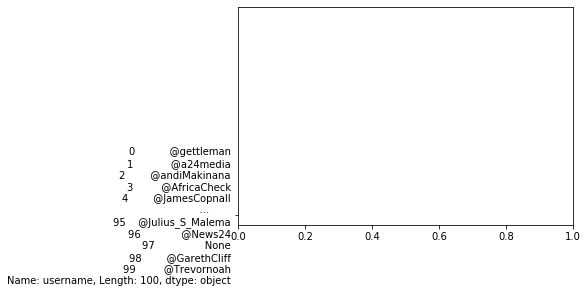

In [57]:
import numpy as np
fig, ax = plt.subplots()
T = np.array(tweets)
# print(T)
U = np.array(handle)
print(U)
plt.plot(U, T, kind='bar', rot=0)
ax.set_title('influencers by hashtag', fontsize=16)
ax.set_xlabel('handle', fontsize=15)
ax.set_ylabel('tweets',fontsize=15)
